In [3]:
import ipynb_setup

import numpy as np
import pandas as pd

from src.data_loader.data_loader import Dataset

from src.model.catboost_model import CatBoost
from src.model.adaboost import AdaBoost
from src.model.extra_tree import ExtraTree
from src.model.lgbm import LGBM
from src.model.xgb import XGB

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline

In [4]:
CATEGORICAL_FEATURES = ['Condition', 'Clouds', 'Day/Night', 'Snow_Priority']
path = '../data/merged_data_2.csv'
dataset = Dataset(path, CATEGORICAL_FEATURES)
x, x_test, y, y_test = dataset.clean_and_encode_data()
len(x), len(x_test)

/home/milica/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Creating ordinal representations of circular features (Month/Year/Weekday/Minute)
Columns: ['FeelsLike', 'Precip.', 'StreetWidth_Min', 'POSTED_SPEED', 'Number_Travel_Lanes', 'Number_Park_Lanes', 'Number_Total_Lanes', 'LL_X', 'LL_Y', 'LL_Z', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'DOW_SIN', 'DOW_COS', 'Condition_CLD', 'Condition_LVS', 'Condition_RD', 'Clouds_BKN', 'Clouds_CLR', 'Clouds_FEW', 'Clouds_OVC', 'Clouds_SCT', 'Day/Night_D', 'Day/Night_N', 'Snow_Priority_C', 'Snow_Priority_H', 'Snow_Priority_S', 'Snow_Priority_V']


(653906, 72657)

In [5]:
df = pd.read_csv(path)
df.columns

/home/milica/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'ON STREET NAME', 'HOUR', 'Temperature', 'FeelsLike',
       'Dew', 'Humidity', 'Wind', 'WindSpeed', 'Pressure', 'Precip.',
       'Condition', 'Day/Night', 'Clouds', 'SEVERITY', 'geometry', 'NonPed',
       'StreetWidth_Min', 'XFrom', 'YFrom', 'XTo', 'YTo', 'POSTED_SPEED',
       'Snow_Priority', 'Number_Travel_Lanes', 'Number_Park_Lanes',
       'Number_Total_Lanes', 'TRUCK_ROUTE_TYPE'],
      dtype='object')

In [6]:
from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y)
print(counter)
# define pipeline
under = RandomUnderSampler(sampling_strategy=0.35, random_state=42)
over = SMOTE(sampling_strategy=0.5, random_state=42)
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x_new, y_new = pipeline.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(y_new)
print(counter)

class_weights = compute_sample_weight('balanced', y_new)

Counter({0: 531914, 1: 121992})
Counter({0: 348548, 1: 174274})


In [15]:
# from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def train_extra_trees_model(x, y):
    class_weights = compute_sample_weight('balanced', y)
    parameters = {'n_estimators':[30, 40, 50, 75], 'max_depth':[None, 3, 5, 7, 10],
                 'max_features':['auto', 'log2', 0.4, 0.8], 'bootstrap': [True, False]}
    etc = ExtraTreesClassifier(random_state = 42)
    clf = HalvingGridSearchCV(etc, parameters, return_train_score=True, verbose=3)
    extra_tree_model = clf.fit(x, y, sample_weight=class_weights)
    return extra_tree_model

def train_model_lgbm(x, y):
    class_weights = compute_sample_weight('balanced', y)
    parameters = {'n_estimators':[100, 80, 120],
                  'learning_rate': [0.05, 0.1, 0.3], 
                  'num_leaves':[23, 31, 45],
                  'max_depth':[-1, 3, 5, 7], 
                 'feature_fraction':[1.0, 0.9, 0.7]}
    lgbm_model = LGBMClassifier(random_state = 42, application='binary')
    clf = HalvingGridSearchCV(lgbm_model, parameters, return_train_score=True, verbose=1)
    model = clf.fit(x, y, sample_weight=class_weights)
    return model

def train_xgbost(x, y):
    param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
    }
    gsearch1 = HalvingGridSearchCV(XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
        gamma=0, subsample=0.8, colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        seed=27,
        num_class=2,
        verbose=1,
        use_label_encoder=False), param_grid = param_test1, n_jobs=-1, return_train_score=True, verbose=3)
    class_weights = compute_sample_weight('balanced', y)
    gsearch1.fit(x, y, sample_weight=class_weights)
    return gsearch1

def train_CatBoost(x, y):
    class_weights = compute_sample_weight('balanced', y)
    #'boosting':['gbdt', 'goss'], 
    parameters = {
                  'learning_rate': [0.1, 0.3, 0.5], 
                  'depth':[4, 7, 10]
                 }
    cat = CatBoostClassifier(auto_class_weights='Balanced', 
                             l2_leaf_reg=3.5, rsm=0.98, verbose=50,
                            iterations=2800)
    clf = HalvingGridSearchCV(cat, parameters, return_train_score=True, verbose=1)
#     etc = ExtraTreesClassifier(n_estimators=50, random_state=42,bootstrap=True, verbose=2)    
    model = clf.fit(x, y, sample_weight=class_weights)
    return model

In [8]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(extra_tree_model, x, y_test):
    prediction = extra_tree_model.predict(x)
    accuracy = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    f1_2 = f1_score(y_test, prediction, average='weighted')
    report = classification_report(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n ROC_AUC: \n {roc_auc} \n Classification report: \n {report}')

    print(confusion_matrix(prediction, y_test))

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

    plt.show()
    
import pickle

def save_model(file_name, model):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

In [9]:
def plot_importance(importance, feature_name, ax=None, height=0.2,
                    xlim=None, ylim=None, title='Feature importance',
                    xlabel='Feature importance', ylabel='Features',
                    importance_type='split', max_num_features=None,
                    ignore_zero=True, figsize=None, dpi=None, grid=True,
                    precision=3, **kwargs):

    tuples = sorted(zip(feature_name, importance), key=lambda x: x[1])
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
    if max_num_features is not None and max_num_features > 0:
        tuples = tuples[-max_num_features:]
    labels, values = zip(*tuples)

    if ax is None:
        if figsize is not None:
            _check_not_tuple_of_2_elements(figsize, 'figsize')
        _, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=height, **kwargs)

    for x, y in zip(values, ylocs):
        ax.text(x + 1, y,
                _float2str(x, precision) if importance_type == 'gain' else x,
                va='center')

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)

    if xlim is not None:
        _check_not_tuple_of_2_elements(xlim, 'xlim')
    else:
        xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)

    if ylim is not None:
        _check_not_tuple_of_2_elements(ylim, 'ylim')
    else:
        ylim = (-1, len(values))
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(grid)
    return ax

Accuracy: 
 0.780365277949819 
 F1: 
 0.780365277949819 
 F1_2: 
 0.7337835891786569 
 ROC_AUC: 
 0.514936310107532 
 Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.87     58912
           1       0.26      0.09      0.13     13745

    accuracy                           0.78     72657
   macro avg       0.54      0.51      0.50     72657
weighted avg       0.71      0.78      0.73     72657

[[55490 12536]
 [ 3422  1209]]


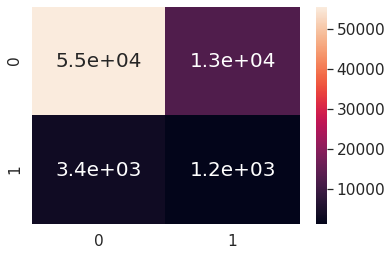

ExtraTreesClassifier(bootstrap=True, max_features=0.4, n_estimators=75,
                     random_state=42)
0.7431980791082277
{'bootstrap': True, 'max_depth': None, 'max_features': 0.4, 'n_estimators': 75}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

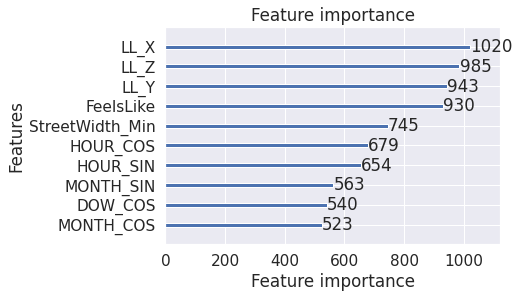

In [19]:
# extra_tree_model = train_extra_trees_model(x_new, y_new)
test_model(extra_tree_model, x_test, y_test)
file_name = './extraTreeFinal.pkl'
save_model(file_name, extra_tree_model)
print(extra_tree_model.best_estimator_)
print(extra_tree_model.best_score_)
print(extra_tree_model.best_params_)
plot_importance((extra_tree_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 2151
max_resources_: 522822
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 324
n_resources: 2151
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

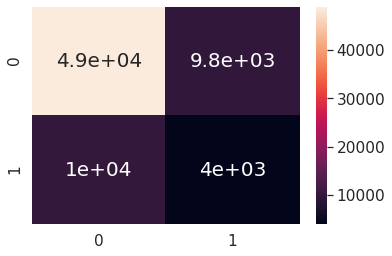

LGBMClassifier(application='binary', feature_fraction=1.0, num_leaves=45,
               random_state=42)
0.6926591287378752
{'feature_fraction': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 45}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

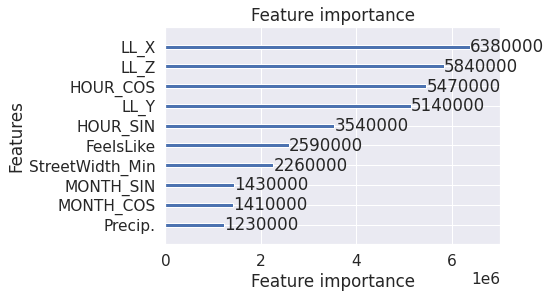

In [16]:
lgbm_model = train_model_lgbm(x_new, y_new)
test_model(lgbm_model, x_test, y_test)
file_name = './lgbmFinal.pkl'
save_model(file_name, lgbm_model)
print(lgbm_model.best_estimator_)
print(lgbm_model.best_score_)
print(lgbm_model.best_params_)
plot_importance((lgbm_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 58091
max_resources_: 522822
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 58091
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 174273
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 522819
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[02:52:30] WARNING: ../src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:52:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogl

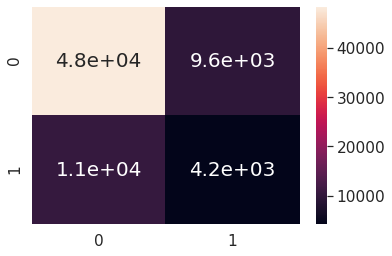

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_class=2,
              num_parallel_tree=1, objective='multi:softmax', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=27,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
0.6988488837234463
{'max_depth': 9, 'min_child_weight': 1}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

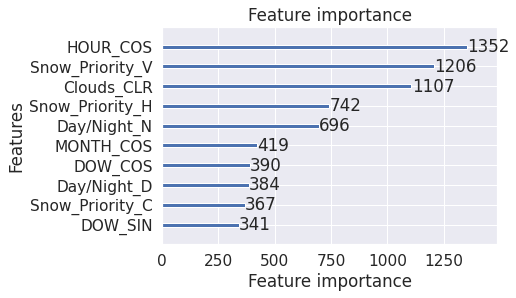

In [21]:
xgboost_model = train_xgbost(x_new, y_new)
test_model(xgboost_model, x_test, y_test)
file_name = './xgboost_modelFinal.pkl'
save_model(file_name, xgboost_model)
print(xgboost_model.best_estimator_)
print(xgboost_model.best_score_)
print(xgboost_model.best_params_)
plot_importance((xgboost_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 58091
max_resources_: 522822
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 58091
Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 0.6865490	total: 80ms	remaining: 3m 43s
50:	learn: 0.5865135	total: 817ms	remaining: 44.1s
100:	learn: 0.5643108	total: 1.69s	remaining: 45.2s
150:	learn: 0.5528258	total: 2.5s	remaining: 43.9s
200:	learn: 0.5446676	total: 3.42s	remaining: 44.3s
250:	learn: 0.5376509	total: 4.18s	remaining: 42.5s
300:	learn: 0.5330404	total: 5.05s	remaining: 41.9s
350:	learn: 0.5294115	total: 5.83s	remaining: 40.7s
400:	learn: 0.5261543	total: 6.62s	remaining: 39.6s
450:	learn: 0.5230191	total: 7.39s	remaining: 38.5s
500:	learn: 0.5201796	total: 8.22s	remaining: 37.7s
550:	learn: 0.5174780	total: 9s	remaining: 36.7s
600:	learn: 0.5146682	total: 9.82s	remaining: 35.9s
650:	learn: 0.5119324	total: 10.6s	remaining: 34.9s
700:	learn: 0.

1950:	learn: 0.4703873	total: 31.3s	remaining: 13.6s
2000:	learn: 0.4688695	total: 32.1s	remaining: 12.8s
2050:	learn: 0.4672757	total: 32.9s	remaining: 12s
2100:	learn: 0.4657267	total: 33.6s	remaining: 11.2s
2150:	learn: 0.4642980	total: 34.5s	remaining: 10.4s
2200:	learn: 0.4628184	total: 35.2s	remaining: 9.59s
2250:	learn: 0.4613086	total: 36s	remaining: 8.78s
2300:	learn: 0.4597223	total: 36.8s	remaining: 7.97s
2350:	learn: 0.4583419	total: 37.5s	remaining: 7.17s
2400:	learn: 0.4568412	total: 38.3s	remaining: 6.37s
2450:	learn: 0.4550655	total: 39.1s	remaining: 5.57s
2500:	learn: 0.4535280	total: 40s	remaining: 4.78s
2550:	learn: 0.4522059	total: 40.8s	remaining: 3.98s
2600:	learn: 0.4508098	total: 41.6s	remaining: 3.18s
2650:	learn: 0.4495415	total: 42.4s	remaining: 2.38s
2700:	learn: 0.4481711	total: 43.1s	remaining: 1.58s
2750:	learn: 0.4467368	total: 44s	remaining: 783ms
2799:	learn: 0.4453284	total: 44.8s	remaining: 0us
0:	learn: 0.6886955	total: 30.5ms	remaining: 1m 25s
50:	

1300:	learn: 0.4052172	total: 21s	remaining: 24.2s
1350:	learn: 0.4018136	total: 21.9s	remaining: 23.5s
1400:	learn: 0.3982222	total: 22.7s	remaining: 22.6s
1450:	learn: 0.3948003	total: 23.4s	remaining: 21.8s
1500:	learn: 0.3911384	total: 24.2s	remaining: 20.9s
1550:	learn: 0.3880809	total: 25s	remaining: 20.1s
1600:	learn: 0.3844798	total: 25.8s	remaining: 19.3s
1650:	learn: 0.3813450	total: 26.7s	remaining: 18.6s
1700:	learn: 0.3780466	total: 27.4s	remaining: 17.7s
1750:	learn: 0.3749379	total: 28.2s	remaining: 16.9s
1800:	learn: 0.3717153	total: 29.1s	remaining: 16.1s
1850:	learn: 0.3686101	total: 30s	remaining: 15.4s
1900:	learn: 0.3657577	total: 31s	remaining: 14.7s
1950:	learn: 0.3630536	total: 32s	remaining: 13.9s
2000:	learn: 0.3601340	total: 32.9s	remaining: 13.2s
2050:	learn: 0.3571544	total: 33.9s	remaining: 12.4s
2100:	learn: 0.3543052	total: 34.7s	remaining: 11.5s
2150:	learn: 0.3516781	total: 35.5s	remaining: 10.7s
2200:	learn: 0.3489369	total: 36.4s	remaining: 9.9s
2250

600:	learn: 0.5185131	total: 9.41s	remaining: 34.4s
650:	learn: 0.5138004	total: 10.3s	remaining: 33.9s
700:	learn: 0.5093428	total: 11.1s	remaining: 33.2s
750:	learn: 0.5049629	total: 12.1s	remaining: 32.9s
800:	learn: 0.5006461	total: 12.9s	remaining: 32.1s
850:	learn: 0.4961969	total: 13.7s	remaining: 31.3s
900:	learn: 0.4922439	total: 14.5s	remaining: 30.6s
950:	learn: 0.4884524	total: 15.3s	remaining: 29.8s
1000:	learn: 0.4842576	total: 16.1s	remaining: 29s
1050:	learn: 0.4800820	total: 16.9s	remaining: 28.2s
1100:	learn: 0.4763151	total: 17.8s	remaining: 27.5s
1150:	learn: 0.4722288	total: 18.6s	remaining: 26.6s
1200:	learn: 0.4685223	total: 19.5s	remaining: 25.9s
1250:	learn: 0.4650198	total: 20.2s	remaining: 25.1s
1300:	learn: 0.4614932	total: 21s	remaining: 24.2s
1350:	learn: 0.4579332	total: 21.9s	remaining: 23.5s
1400:	learn: 0.4546692	total: 22.6s	remaining: 22.6s
1450:	learn: 0.4516021	total: 23.4s	remaining: 21.7s
1500:	learn: 0.4482842	total: 24.2s	remaining: 20.9s
1550:

2750:	learn: 0.2452521	total: 45.5s	remaining: 810ms
2799:	learn: 0.2421877	total: 46.2s	remaining: 0us
0:	learn: 0.6750903	total: 21.1ms	remaining: 59.1s
50:	learn: 0.5414378	total: 946ms	remaining: 51s
100:	learn: 0.5222334	total: 1.75s	remaining: 46.9s
150:	learn: 0.5103960	total: 2.47s	remaining: 43.3s
200:	learn: 0.4994059	total: 3.22s	remaining: 41.6s
250:	learn: 0.4896841	total: 4s	remaining: 40.7s
300:	learn: 0.4806927	total: 4.8s	remaining: 39.9s
350:	learn: 0.4715573	total: 5.54s	remaining: 38.7s
400:	learn: 0.4636578	total: 6.34s	remaining: 37.9s
450:	learn: 0.4557666	total: 7.22s	remaining: 37.6s
500:	learn: 0.4484926	total: 8.02s	remaining: 36.8s
550:	learn: 0.4415131	total: 8.78s	remaining: 35.8s
600:	learn: 0.4349315	total: 9.51s	remaining: 34.8s
650:	learn: 0.4278724	total: 10.3s	remaining: 34s
700:	learn: 0.4216567	total: 11.1s	remaining: 33.2s
750:	learn: 0.4151206	total: 11.8s	remaining: 32.3s
800:	learn: 0.4089287	total: 12.6s	remaining: 31.4s
850:	learn: 0.4026082	

2100:	learn: 0.3449726	total: 33.6s	remaining: 11.2s
2150:	learn: 0.3416844	total: 34.4s	remaining: 10.4s
2200:	learn: 0.3380504	total: 35.1s	remaining: 9.55s
2250:	learn: 0.3346661	total: 35.8s	remaining: 8.74s
2300:	learn: 0.3312006	total: 36.7s	remaining: 7.97s
2350:	learn: 0.3279736	total: 37.6s	remaining: 7.19s
2400:	learn: 0.3248295	total: 38.5s	remaining: 6.4s
2450:	learn: 0.3212628	total: 39.2s	remaining: 5.59s
2500:	learn: 0.3180677	total: 40s	remaining: 4.79s
2550:	learn: 0.3149672	total: 40.9s	remaining: 3.99s
2600:	learn: 0.3119769	total: 41.6s	remaining: 3.19s
2650:	learn: 0.3088925	total: 42.3s	remaining: 2.38s
2700:	learn: 0.3057551	total: 43.2s	remaining: 1.58s
2750:	learn: 0.3028785	total: 44s	remaining: 783ms
2799:	learn: 0.3002608	total: 44.8s	remaining: 0us
0:	learn: 0.6839458	total: 10.4ms	remaining: 29.1s
50:	learn: 0.6331989	total: 760ms	remaining: 41s
100:	learn: 0.6164318	total: 1.61s	remaining: 43.1s
150:	learn: 0.6046780	total: 2.44s	remaining: 42.8s
200:	lea

1450:	learn: 0.3283178	total: 35.2s	remaining: 32.7s
1500:	learn: 0.3234736	total: 36.4s	remaining: 31.5s
1550:	learn: 0.3187457	total: 37.6s	remaining: 30.3s
1600:	learn: 0.3140710	total: 38.8s	remaining: 29s
1650:	learn: 0.3096056	total: 39.9s	remaining: 27.8s
1700:	learn: 0.3048551	total: 41.2s	remaining: 26.6s
1750:	learn: 0.3002637	total: 42.4s	remaining: 25.4s
1800:	learn: 0.2957738	total: 43.7s	remaining: 24.2s
1850:	learn: 0.2915159	total: 45.1s	remaining: 23.1s
1900:	learn: 0.2871836	total: 46.3s	remaining: 21.9s
1950:	learn: 0.2829762	total: 47.5s	remaining: 20.7s
2000:	learn: 0.2789977	total: 48.7s	remaining: 19.4s
2050:	learn: 0.2752005	total: 49.9s	remaining: 18.2s
2100:	learn: 0.2712816	total: 51.1s	remaining: 17s
2150:	learn: 0.2673322	total: 52.3s	remaining: 15.8s
2200:	learn: 0.2635094	total: 53.6s	remaining: 14.6s
2250:	learn: 0.2598799	total: 54.8s	remaining: 13.4s
2300:	learn: 0.2565041	total: 55.9s	remaining: 12.1s
2350:	learn: 0.2533144	total: 57.1s	remaining: 10.

750:	learn: 0.5023133	total: 18.6s	remaining: 50.6s
800:	learn: 0.4955529	total: 19.9s	remaining: 49.6s
850:	learn: 0.4886277	total: 21s	remaining: 48.2s
900:	learn: 0.4823864	total: 22.2s	remaining: 46.9s
950:	learn: 0.4759288	total: 23.5s	remaining: 45.6s
1000:	learn: 0.4696427	total: 24.7s	remaining: 44.4s
1050:	learn: 0.4637224	total: 25.9s	remaining: 43.1s
1100:	learn: 0.4576972	total: 27.1s	remaining: 41.9s
1150:	learn: 0.4519639	total: 28.4s	remaining: 40.7s
1200:	learn: 0.4461548	total: 29.6s	remaining: 39.5s
1250:	learn: 0.4407747	total: 30.8s	remaining: 38.2s
1300:	learn: 0.4358388	total: 32.1s	remaining: 37s
1350:	learn: 0.4305852	total: 33.2s	remaining: 35.7s
1400:	learn: 0.4259808	total: 34.4s	remaining: 34.4s
1450:	learn: 0.4209424	total: 35.7s	remaining: 33.2s
1500:	learn: 0.4161442	total: 37s	remaining: 32s
1550:	learn: 0.4113959	total: 38.2s	remaining: 30.8s
1600:	learn: 0.4062919	total: 39.3s	remaining: 29.5s
1650:	learn: 0.4015767	total: 40.6s	remaining: 28.3s
1700:	

50:	learn: 0.5360346	total: 1.19s	remaining: 1m 4s
100:	learn: 0.4969159	total: 2.51s	remaining: 1m 7s
150:	learn: 0.4676073	total: 3.64s	remaining: 1m 3s
200:	learn: 0.4425406	total: 4.81s	remaining: 1m 2s
250:	learn: 0.4190115	total: 6.09s	remaining: 1m 1s
300:	learn: 0.3979631	total: 7.32s	remaining: 1m
350:	learn: 0.3777662	total: 8.5s	remaining: 59.3s
400:	learn: 0.3584537	total: 9.85s	remaining: 59s
450:	learn: 0.3430190	total: 11.2s	remaining: 58.3s
500:	learn: 0.3267695	total: 12.3s	remaining: 56.4s
550:	learn: 0.3125883	total: 13.5s	remaining: 55s
600:	learn: 0.2991311	total: 14.7s	remaining: 53.7s
650:	learn: 0.2866732	total: 16s	remaining: 52.8s
700:	learn: 0.2741417	total: 17.2s	remaining: 51.5s
750:	learn: 0.2629698	total: 18.4s	remaining: 50.2s
800:	learn: 0.2521799	total: 19.7s	remaining: 49.1s
850:	learn: 0.2423071	total: 21.1s	remaining: 48.2s
900:	learn: 0.2318984	total: 22.4s	remaining: 47.1s
950:	learn: 0.2230075	total: 23.6s	remaining: 45.9s
1000:	learn: 0.2140331	

2200:	learn: 0.1392093	total: 55.7s	remaining: 15.2s
2250:	learn: 0.1351927	total: 56.9s	remaining: 13.9s
2300:	learn: 0.1309902	total: 58.1s	remaining: 12.6s
2350:	learn: 0.1273695	total: 59.5s	remaining: 11.4s
2400:	learn: 0.1239368	total: 1m	remaining: 10.1s
2450:	learn: 0.1206750	total: 1m 2s	remaining: 8.83s
2500:	learn: 0.1175680	total: 1m 3s	remaining: 7.55s
2550:	learn: 0.1144548	total: 1m 4s	remaining: 6.29s
2600:	learn: 0.1109301	total: 1m 5s	remaining: 5.03s
2650:	learn: 0.1080636	total: 1m 6s	remaining: 3.76s
2700:	learn: 0.1048573	total: 1m 8s	remaining: 2.5s
2750:	learn: 0.1021854	total: 1m 9s	remaining: 1.24s
2799:	learn: 0.0993529	total: 1m 10s	remaining: 0us
0:	learn: 0.6613714	total: 36.9ms	remaining: 1m 43s
50:	learn: 0.5021991	total: 1.18s	remaining: 1m 3s
100:	learn: 0.4556432	total: 2.5s	remaining: 1m 6s
150:	learn: 0.4165400	total: 3.8s	remaining: 1m 6s
200:	learn: 0.3812339	total: 4.82s	remaining: 1m 2s
250:	learn: 0.3536983	total: 5.51s	remaining: 55.9s
300:	le

1550:	learn: 0.0688645	total: 39.1s	remaining: 31.5s
1600:	learn: 0.0652823	total: 40.3s	remaining: 30.2s
1650:	learn: 0.0618560	total: 41.5s	remaining: 28.9s
1700:	learn: 0.0584816	total: 42.7s	remaining: 27.6s
1750:	learn: 0.0553668	total: 44.1s	remaining: 26.4s
1800:	learn: 0.0526757	total: 45.3s	remaining: 25.1s
1850:	learn: 0.0501223	total: 46.5s	remaining: 23.8s
1900:	learn: 0.0475290	total: 47.7s	remaining: 22.6s
1950:	learn: 0.0451985	total: 48.9s	remaining: 21.3s
2000:	learn: 0.0431409	total: 50.1s	remaining: 20s
2050:	learn: 0.0410542	total: 51.3s	remaining: 18.7s
2100:	learn: 0.0392818	total: 52.6s	remaining: 17.5s
2150:	learn: 0.0377047	total: 53.7s	remaining: 16.2s
2200:	learn: 0.0359814	total: 55s	remaining: 15s
2250:	learn: 0.0344433	total: 56.3s	remaining: 13.7s
2300:	learn: 0.0329738	total: 57.5s	remaining: 12.5s
2350:	learn: 0.0316939	total: 58.7s	remaining: 11.2s
2400:	learn: 0.0304146	total: 59.9s	remaining: 9.95s
2450:	learn: 0.0291706	total: 1m 1s	remaining: 8.7s


850:	learn: 0.1882835	total: 1m 22s	remaining: 3m 8s
900:	learn: 0.1787010	total: 1m 27s	remaining: 3m 3s
950:	learn: 0.1693833	total: 1m 31s	remaining: 2m 58s
1000:	learn: 0.1606925	total: 1m 36s	remaining: 2m 53s
1050:	learn: 0.1528547	total: 1m 41s	remaining: 2m 48s
1100:	learn: 0.1452020	total: 1m 45s	remaining: 2m 43s
1150:	learn: 0.1380947	total: 1m 50s	remaining: 2m 38s
1200:	learn: 0.1312785	total: 1m 55s	remaining: 2m 34s
1250:	learn: 0.1248676	total: 2m	remaining: 2m 28s
1300:	learn: 0.1190723	total: 2m 5s	remaining: 2m 24s
1350:	learn: 0.1138106	total: 2m 9s	remaining: 2m 19s
1400:	learn: 0.1088128	total: 2m 14s	remaining: 2m 14s
1450:	learn: 0.1041135	total: 2m 19s	remaining: 2m 9s
1500:	learn: 0.0995525	total: 2m 24s	remaining: 2m 4s
1550:	learn: 0.0953429	total: 2m 29s	remaining: 2m
1600:	learn: 0.0916200	total: 2m 33s	remaining: 1m 55s
1650:	learn: 0.0877953	total: 2m 38s	remaining: 1m 50s
1700:	learn: 0.0842218	total: 2m 43s	remaining: 1m 45s
1750:	learn: 0.0808663	tota

2799:	learn: 0.0412545	total: 4m 28s	remaining: 0us
0:	learn: 0.6869022	total: 149ms	remaining: 6m 57s
50:	learn: 0.5867002	total: 4.81s	remaining: 4m 19s
100:	learn: 0.5459801	total: 9.39s	remaining: 4m 10s
150:	learn: 0.5092558	total: 14.2s	remaining: 4m 9s
200:	learn: 0.4755765	total: 19s	remaining: 4m 5s
250:	learn: 0.4456509	total: 23.5s	remaining: 3m 58s
300:	learn: 0.4187579	total: 28.1s	remaining: 3m 53s
350:	learn: 0.3952679	total: 32.8s	remaining: 3m 48s
400:	learn: 0.3709003	total: 37.8s	remaining: 3m 46s
450:	learn: 0.3494331	total: 42.6s	remaining: 3m 41s
500:	learn: 0.3297200	total: 47.3s	remaining: 3m 37s
550:	learn: 0.3110200	total: 52.1s	remaining: 3m 32s
600:	learn: 0.2941589	total: 56.8s	remaining: 3m 27s
650:	learn: 0.2799736	total: 1m 1s	remaining: 3m 23s
700:	learn: 0.2662968	total: 1m 6s	remaining: 3m 19s
750:	learn: 0.2527467	total: 1m 11s	remaining: 3m 15s
800:	learn: 0.2412314	total: 1m 16s	remaining: 3m 10s
850:	learn: 0.2298153	total: 1m 21s	remaining: 3m 5s

1900:	learn: 0.0136422	total: 2m 49s	remaining: 1m 19s
1950:	learn: 0.0135424	total: 2m 51s	remaining: 1m 14s
2000:	learn: 0.0133747	total: 2m 55s	remaining: 1m 9s
2050:	learn: 0.0133104	total: 2m 57s	remaining: 1m 4s
2100:	learn: 0.0132285	total: 3m	remaining: 1m
2150:	learn: 0.0131845	total: 3m 3s	remaining: 55.4s
2200:	learn: 0.0130749	total: 3m 6s	remaining: 50.7s
2250:	learn: 0.0129940	total: 3m 9s	remaining: 46.1s
2300:	learn: 0.0129446	total: 3m 11s	remaining: 41.6s
2350:	learn: 0.0129126	total: 3m 14s	remaining: 37.2s
2400:	learn: 0.0128567	total: 3m 17s	remaining: 32.8s
2450:	learn: 0.0128266	total: 3m 19s	remaining: 28.5s
2500:	learn: 0.0127972	total: 3m 22s	remaining: 24.2s
2550:	learn: 0.0127702	total: 3m 25s	remaining: 20.1s
2600:	learn: 0.0127272	total: 3m 28s	remaining: 15.9s
2650:	learn: 0.0126877	total: 3m 30s	remaining: 11.8s
2700:	learn: 0.0126689	total: 3m 33s	remaining: 7.83s
2750:	learn: 0.0126288	total: 3m 36s	remaining: 3.85s
2799:	learn: 0.0125904	total: 3m 38s

1050:	learn: 0.0391258	total: 1m 38s	remaining: 2m 44s
1100:	learn: 0.0361742	total: 1m 43s	remaining: 2m 39s
1150:	learn: 0.0336120	total: 1m 48s	remaining: 2m 35s
1200:	learn: 0.0311810	total: 1m 52s	remaining: 2m 30s
1250:	learn: 0.0290303	total: 1m 57s	remaining: 2m 25s
1300:	learn: 0.0270210	total: 2m 2s	remaining: 2m 20s
1350:	learn: 0.0253826	total: 2m 6s	remaining: 2m 16s
1400:	learn: 0.0237240	total: 2m 11s	remaining: 2m 11s
1450:	learn: 0.0224404	total: 2m 16s	remaining: 2m 6s
1500:	learn: 0.0212303	total: 2m 20s	remaining: 2m 1s
1550:	learn: 0.0201591	total: 2m 25s	remaining: 1m 56s
1600:	learn: 0.0191867	total: 2m 29s	remaining: 1m 51s
1650:	learn: 0.0182398	total: 2m 33s	remaining: 1m 47s
1700:	learn: 0.0175545	total: 2m 37s	remaining: 1m 42s
1750:	learn: 0.0168806	total: 2m 41s	remaining: 1m 36s
1800:	learn: 0.0164554	total: 2m 45s	remaining: 1m 31s
1850:	learn: 0.0159712	total: 2m 48s	remaining: 1m 26s
1900:	learn: 0.0156491	total: 2m 52s	remaining: 1m 21s
1950:	learn: 0

150:	learn: 0.2251031	total: 15.5s	remaining: 4m 31s
200:	learn: 0.1706982	total: 20.2s	remaining: 4m 20s
250:	learn: 0.1306795	total: 25s	remaining: 4m 13s
300:	learn: 0.1028778	total: 29.7s	remaining: 4m 6s
350:	learn: 0.0821053	total: 34.6s	remaining: 4m 1s
400:	learn: 0.0660263	total: 39.3s	remaining: 3m 55s
450:	learn: 0.0543484	total: 44.4s	remaining: 3m 51s
500:	learn: 0.0452714	total: 49.1s	remaining: 3m 45s
550:	learn: 0.0381180	total: 53.8s	remaining: 3m 39s
600:	learn: 0.0324641	total: 58.4s	remaining: 3m 33s
650:	learn: 0.0281294	total: 1m 3s	remaining: 3m 28s
700:	learn: 0.0246725	total: 1m 8s	remaining: 3m 24s
750:	learn: 0.0217194	total: 1m 12s	remaining: 3m 18s
800:	learn: 0.0192527	total: 1m 17s	remaining: 3m 13s
850:	learn: 0.0171976	total: 1m 22s	remaining: 3m 8s
900:	learn: 0.0156367	total: 1m 26s	remaining: 3m 2s
950:	learn: 0.0144950	total: 1m 30s	remaining: 2m 55s
1000:	learn: 0.0137900	total: 1m 33s	remaining: 2m 48s
1050:	learn: 0.0136274	total: 1m 36s	remainin

2100:	learn: 0.0126273	total: 2m 40s	remaining: 53.4s
2150:	learn: 0.0126120	total: 2m 43s	remaining: 49.2s
2200:	learn: 0.0125967	total: 2m 45s	remaining: 45.1s
2250:	learn: 0.0125932	total: 2m 48s	remaining: 41.1s
2300:	learn: 0.0125821	total: 2m 50s	remaining: 37.1s
2350:	learn: 0.0125760	total: 2m 53s	remaining: 33.2s
2400:	learn: 0.0125493	total: 2m 56s	remaining: 29.3s
2450:	learn: 0.0125422	total: 2m 58s	remaining: 25.5s
2500:	learn: 0.0125374	total: 3m 1s	remaining: 21.7s
2550:	learn: 0.0125340	total: 3m 4s	remaining: 18s
2600:	learn: 0.0125163	total: 3m 6s	remaining: 14.3s
2650:	learn: 0.0125142	total: 3m 9s	remaining: 10.7s
2700:	learn: 0.0125002	total: 3m 12s	remaining: 7.05s
2750:	learn: 0.0124727	total: 3m 15s	remaining: 3.47s
2799:	learn: 0.0124637	total: 3m 17s	remaining: 0us
0:	learn: 0.6748189	total: 120ms	remaining: 5m 36s
50:	learn: 0.4885114	total: 4.85s	remaining: 4m 21s
100:	learn: 0.3788440	total: 9.79s	remaining: 4m 21s
150:	learn: 0.2951836	total: 14.5s	remaini

1150:	learn: 0.4571906	total: 1m 3s	remaining: 1m 30s
1200:	learn: 0.4542380	total: 1m 5s	remaining: 1m 27s
1250:	learn: 0.4511275	total: 1m 8s	remaining: 1m 24s
1300:	learn: 0.4483879	total: 1m 11s	remaining: 1m 22s
1350:	learn: 0.4455908	total: 1m 14s	remaining: 1m 19s
1400:	learn: 0.4428717	total: 1m 17s	remaining: 1m 17s
1450:	learn: 0.4400904	total: 1m 19s	remaining: 1m 14s
1500:	learn: 0.4374216	total: 1m 22s	remaining: 1m 11s
1550:	learn: 0.4349127	total: 1m 25s	remaining: 1m 8s
1600:	learn: 0.4325384	total: 1m 27s	remaining: 1m 5s
1650:	learn: 0.4300584	total: 1m 30s	remaining: 1m 3s
1700:	learn: 0.4275500	total: 1m 33s	remaining: 1m
1750:	learn: 0.4250577	total: 1m 36s	remaining: 57.6s
1800:	learn: 0.4225474	total: 1m 38s	remaining: 54.8s
1850:	learn: 0.4200633	total: 1m 41s	remaining: 52s
1900:	learn: 0.4176217	total: 1m 44s	remaining: 49.2s
1950:	learn: 0.4154404	total: 1m 46s	remaining: 46.4s
2000:	learn: 0.4132869	total: 1m 49s	remaining: 43.7s
2050:	learn: 0.4108758	total

300:	learn: 0.6145065	total: 16.3s	remaining: 2m 14s
350:	learn: 0.6106987	total: 18.9s	remaining: 2m 12s
400:	learn: 0.6065439	total: 21.6s	remaining: 2m 9s
450:	learn: 0.6022166	total: 24.4s	remaining: 2m 6s
500:	learn: 0.5982991	total: 27.1s	remaining: 2m 4s
550:	learn: 0.5946236	total: 29.7s	remaining: 2m 1s
600:	learn: 0.5909025	total: 32.3s	remaining: 1m 58s
650:	learn: 0.5878043	total: 35s	remaining: 1m 55s
700:	learn: 0.5846399	total: 38.1s	remaining: 1m 54s
750:	learn: 0.5815454	total: 40.9s	remaining: 1m 51s
800:	learn: 0.5781137	total: 43.7s	remaining: 1m 49s
850:	learn: 0.5748514	total: 46.7s	remaining: 1m 46s
900:	learn: 0.5717920	total: 49.6s	remaining: 1m 44s
950:	learn: 0.5688796	total: 52.2s	remaining: 1m 41s
1000:	learn: 0.5661091	total: 55s	remaining: 1m 38s
1050:	learn: 0.5632970	total: 57.8s	remaining: 1m 36s
1100:	learn: 0.5604333	total: 1m	remaining: 1m 33s
1150:	learn: 0.5576011	total: 1m 3s	remaining: 1m 30s
1200:	learn: 0.5548374	total: 1m 5s	remaining: 1m 27s

2250:	learn: 0.0434662	total: 5m 26s	remaining: 1m 19s
2300:	learn: 0.0418646	total: 5m 33s	remaining: 1m 12s
2350:	learn: 0.0403521	total: 5m 40s	remaining: 1m 5s
2400:	learn: 0.0388535	total: 5m 47s	remaining: 57.7s
2450:	learn: 0.0373777	total: 5m 54s	remaining: 50.5s
2500:	learn: 0.0359998	total: 6m 1s	remaining: 43.3s
2550:	learn: 0.0348304	total: 6m 9s	remaining: 36s
2600:	learn: 0.0335827	total: 6m 16s	remaining: 28.8s
2650:	learn: 0.0324888	total: 6m 23s	remaining: 21.5s
2700:	learn: 0.0314319	total: 6m 30s	remaining: 14.3s
2750:	learn: 0.0304048	total: 6m 37s	remaining: 7.08s
2799:	learn: 0.0294186	total: 6m 44s	remaining: 0us
0:	learn: 0.6593295	total: 126ms	remaining: 5m 52s
50:	learn: 0.5094054	total: 7.11s	remaining: 6m 23s
100:	learn: 0.4627929	total: 14.1s	remaining: 6m 16s
150:	learn: 0.4243487	total: 21.3s	remaining: 6m 14s
200:	learn: 0.3911983	total: 28.4s	remaining: 6m 7s
250:	learn: 0.3626594	total: 35.4s	remaining: 5m 59s
300:	learn: 0.3377305	total: 42.7s	remaini

1350:	learn: 0.1569824	total: 3m 12s	remaining: 3m 26s
1400:	learn: 0.1506360	total: 3m 20s	remaining: 3m 19s
1450:	learn: 0.1443886	total: 3m 27s	remaining: 3m 12s
1500:	learn: 0.1389188	total: 3m 34s	remaining: 3m 5s
1550:	learn: 0.1330436	total: 3m 41s	remaining: 2m 58s
1600:	learn: 0.1278769	total: 3m 48s	remaining: 2m 51s
1650:	learn: 0.1225175	total: 3m 55s	remaining: 2m 43s
1700:	learn: 0.1182445	total: 4m 2s	remaining: 2m 36s
1750:	learn: 0.1136716	total: 4m 9s	remaining: 2m 29s
1800:	learn: 0.1092979	total: 4m 16s	remaining: 2m 22s
1850:	learn: 0.1054462	total: 4m 23s	remaining: 2m 15s
1900:	learn: 0.1012302	total: 4m 30s	remaining: 2m 8s
1950:	learn: 0.0972712	total: 4m 38s	remaining: 2m 1s
2000:	learn: 0.0936337	total: 4m 45s	remaining: 1m 53s
2050:	learn: 0.0902615	total: 4m 52s	remaining: 1m 46s
2100:	learn: 0.0871078	total: 4m 59s	remaining: 1m 39s
2150:	learn: 0.0840928	total: 5m 6s	remaining: 1m 32s
2200:	learn: 0.0810092	total: 5m 13s	remaining: 1m 25s
2250:	learn: 0.0

450:	learn: 0.4220716	total: 1m 4s	remaining: 5m 38s
500:	learn: 0.4112465	total: 1m 12s	remaining: 5m 31s
550:	learn: 0.3999480	total: 1m 19s	remaining: 5m 25s
600:	learn: 0.3906654	total: 1m 27s	remaining: 5m 19s
650:	learn: 0.3804162	total: 1m 34s	remaining: 5m 12s
700:	learn: 0.3710687	total: 1m 41s	remaining: 5m 4s
750:	learn: 0.3622338	total: 1m 48s	remaining: 4m 57s
800:	learn: 0.3530291	total: 1m 56s	remaining: 4m 50s
850:	learn: 0.3448004	total: 2m 3s	remaining: 4m 42s
900:	learn: 0.3369610	total: 2m 10s	remaining: 4m 35s
950:	learn: 0.3288791	total: 2m 17s	remaining: 4m 28s
1000:	learn: 0.3205370	total: 2m 25s	remaining: 4m 21s
1050:	learn: 0.3134227	total: 2m 32s	remaining: 4m 14s
1100:	learn: 0.3069449	total: 2m 40s	remaining: 4m 7s
1150:	learn: 0.3002787	total: 2m 47s	remaining: 3m 59s
1200:	learn: 0.2937327	total: 2m 54s	remaining: 3m 52s
1250:	learn: 0.2873761	total: 3m 1s	remaining: 3m 45s
1300:	learn: 0.2809887	total: 3m 9s	remaining: 3m 37s
1350:	learn: 0.2752776	tota

2350:	learn: 0.2687345	total: 5m 42s	remaining: 1m 5s
2400:	learn: 0.2644104	total: 5m 50s	remaining: 58.2s
2450:	learn: 0.2602732	total: 5m 57s	remaining: 50.9s
2500:	learn: 0.2564563	total: 6m 4s	remaining: 43.6s
2550:	learn: 0.2527082	total: 6m 11s	remaining: 36.3s
2600:	learn: 0.2491836	total: 6m 18s	remaining: 28.9s
2650:	learn: 0.2455686	total: 6m 25s	remaining: 21.7s
2700:	learn: 0.2420831	total: 6m 32s	remaining: 14.4s
2750:	learn: 0.2385514	total: 6m 39s	remaining: 7.12s
2799:	learn: 0.2352123	total: 6m 46s	remaining: 0us
----------
iter: 2
n_candidates: 1
n_resources: 522819
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6781457	total: 227ms	remaining: 10m 36s
50:	learn: 0.5504423	total: 13.5s	remaining: 12m 5s
100:	learn: 0.5375042	total: 27.2s	remaining: 12m 7s
150:	learn: 0.5283420	total: 40.7s	remaining: 11m 53s
200:	learn: 0.5197758	total: 54.1s	remaining: 11m 39s
250:	learn: 0.5125071	total: 1m 7s	remaining: 11m 28s
300:	learn: 0.5059405	total: 1

1300:	learn: 0.4080472	total: 2m 43s	remaining: 3m 8s
1350:	learn: 0.4040243	total: 2m 49s	remaining: 3m 2s
1400:	learn: 0.4004003	total: 2m 55s	remaining: 2m 55s
1450:	learn: 0.3965099	total: 3m 2s	remaining: 2m 49s
1500:	learn: 0.3930922	total: 3m 8s	remaining: 2m 43s
1550:	learn: 0.3895015	total: 3m 15s	remaining: 2m 37s
1600:	learn: 0.3862409	total: 3m 21s	remaining: 2m 30s
1650:	learn: 0.3828853	total: 3m 27s	remaining: 2m 24s
1700:	learn: 0.3794134	total: 3m 34s	remaining: 2m 18s
1750:	learn: 0.3762216	total: 3m 40s	remaining: 2m 12s
1800:	learn: 0.3731042	total: 3m 46s	remaining: 2m 5s
1850:	learn: 0.3697938	total: 3m 53s	remaining: 1m 59s
1900:	learn: 0.3664787	total: 3m 59s	remaining: 1m 53s
1950:	learn: 0.3634467	total: 4m 5s	remaining: 1m 46s
2000:	learn: 0.3603806	total: 4m 12s	remaining: 1m 40s
2050:	learn: 0.3572349	total: 4m 18s	remaining: 1m 34s
2100:	learn: 0.3540966	total: 4m 24s	remaining: 1m 28s
2150:	learn: 0.3510307	total: 4m 31s	remaining: 1m 21s
2200:	learn: 0.3

400:	learn: 0.5319004	total: 1m	remaining: 5m 59s
450:	learn: 0.5271120	total: 1m 7s	remaining: 5m 52s
500:	learn: 0.5224318	total: 1m 15s	remaining: 5m 44s
550:	learn: 0.5177781	total: 1m 22s	remaining: 5m 37s
600:	learn: 0.5131078	total: 1m 30s	remaining: 5m 31s
650:	learn: 0.5087943	total: 1m 38s	remaining: 5m 23s
700:	learn: 0.5044193	total: 1m 45s	remaining: 5m 16s
750:	learn: 0.5004747	total: 1m 53s	remaining: 5m 8s
800:	learn: 0.4965526	total: 2m	remaining: 5m 1s
850:	learn: 0.4928332	total: 2m 8s	remaining: 4m 53s
900:	learn: 0.4891309	total: 2m 15s	remaining: 4m 46s
950:	learn: 0.4854666	total: 2m 23s	remaining: 4m 38s
1000:	learn: 0.4819715	total: 2m 31s	remaining: 4m 31s
1050:	learn: 0.4787837	total: 2m 38s	remaining: 4m 23s
1100:	learn: 0.4755464	total: 2m 46s	remaining: 4m 16s
1150:	learn: 0.4722971	total: 2m 54s	remaining: 4m 10s
1200:	learn: 0.4693379	total: 3m 2s	remaining: 4m 2s
1250:	learn: 0.4658442	total: 3m 9s	remaining: 3m 55s
1300:	learn: 0.4629060	total: 3m 17s	

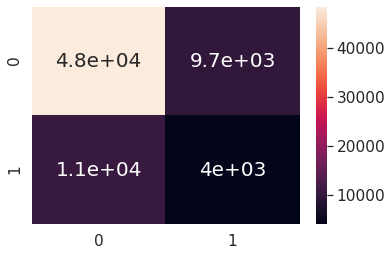

0.698854669377837
{'depth': 10, 'learning_rate': 0.1}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

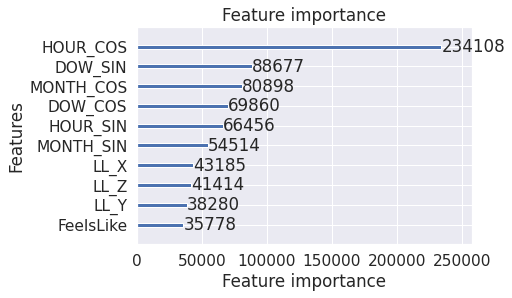

In [22]:
cat_model = train_CatBoost(x_new, y_new)
test_model(cat_model, x_test, y_test)
file_name = './cat_modelFinal.pkl'
save_model(file_name, cat_model)
print(cat_model.best_estimator_)
print(cat_model.best_score_)
print(cat_model.best_params_)
plot_importance((cat_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

In [18]:
import pickle
extra_trees_file = './models/extraTreeFinal.pkl'
lgbm_file = './models/lgbmFinal.pkl'
xgboost_file = './models/xgboost_modelFinal.pkl'
cat_boost_file = './models/cat_modelFinal.pkl'

import pickle
  
with open(extra_trees_file, 'rb') as file:
    extra_trees_model = pickle.load(file)

with open(lgbm_file, 'rb') as file:
    lgbm_model = pickle.load(file)
    
with open(xgboost_file, 'rb') as file:
    xgboost_model = pickle.load(file)

with open(cat_boost_file, 'rb') as file:
    cat_boost_model = pickle.load(file)

### Extra trees

Accuracy: 
 0.780365277949819 
 F1: 
 0.780365277949819 
 F1_2: 
 0.7337835891786569 
 ROC_AUC: 
 0.514936310107532 
 Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.87     58912
           1       0.26      0.09      0.13     13745

    accuracy                           0.78     72657
   macro avg       0.54      0.51      0.50     72657
weighted avg       0.71      0.78      0.73     72657

[[55490 12536]
 [ 3422  1209]]


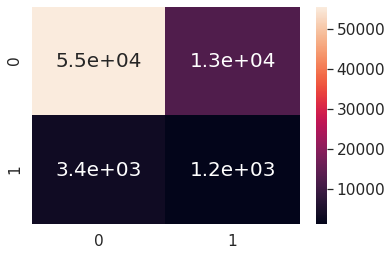

In [19]:
test_model(extra_trees_model, x_test, y_test)

### LGBM

Accuracy: 
 0.7281335590514334 
 F1: 
 0.7281335590514334 
 F1_2: 
 0.728821022815168 
 ROC_AUC: 
 0.5594516222283389 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83     58912
           1       0.28      0.29      0.29     13745

    accuracy                           0.73     72657
   macro avg       0.56      0.56      0.56     72657
weighted avg       0.73      0.73      0.73     72657

[[48944  9785]
 [ 9968  3960]]


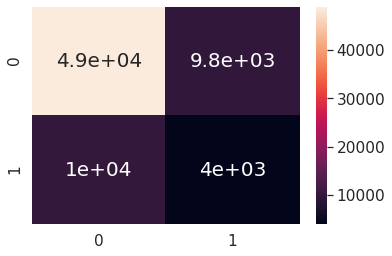

In [20]:
test_model(lgbm_model, x_test, y_test)

### XGBoost

Accuracy: 
 0.7233301677746122 
 F1: 
 0.7233301677746122 
 F1_2: 
 0.7269037159853419 
 ROC_AUC: 
 0.562625295549673 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     58912
           1       0.28      0.30      0.29     13745

    accuracy                           0.72     72657
   macro avg       0.56      0.56      0.56     72657
weighted avg       0.73      0.72      0.73     72657

[[48375  9565]
 [10537  4180]]


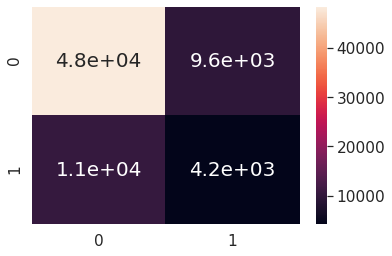

In [21]:
test_model(xgboost_model, x_test, y_test)

### CatBoost

Accuracy: 
 0.7201783723522854 
 F1: 
 0.7201783723522855 
 F1_2: 
 0.7232970572071938 
 ROC_AUC: 
 0.5555500269319207 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     58912
           1       0.27      0.29      0.28     13745

    accuracy                           0.72     72657
   macro avg       0.55      0.56      0.55     72657
weighted avg       0.73      0.72      0.72     72657

[[48330  9749]
 [10582  3996]]


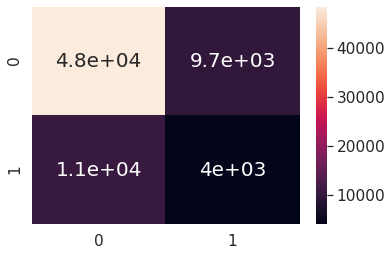

In [22]:
test_model(cat_boost_model, x_test, y_test)

In [27]:
p1 = xgboost_model.predict_proba(x_test)
p2 = lgbm_model.predict_proba(x_test)

prediction = (p1 + p2)/2
prediction = prediction.argmax(axis=1)

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

Accuracy: 
 0.7233301677746122 
 F1: 
 0.7233301677746122 
 F1_2: 
 0.7269037159853419 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     58912
           1       0.28      0.30      0.29     13745

    accuracy                           0.72     72657
   macro avg       0.56      0.56      0.56     72657
weighted avg       0.73      0.72      0.73     72657

